# 생성형 AI의 기초 맛보기 : 스타일 전이 모델 실습

# 1. 구글 코랩과 드라이브를 동기화

In [ ]:
!git clone https://github.com/ballade8/AI_Trend_Edu

In [ ]:
%cd /content/AI_Trend_Edu

In [ ]:
from PIL import Image # 이미지 출력 함수
Image.open("/content/AI_Trend_Edu/아키텍쳐_스타일트123145.png")

# 2. 필요한 라이브러리 불러오기


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dvc

# 3. 코드묶음으로부터 필요한 모듈 정의

In [ ]:
def image_to_tensor(image_filepath, image_dimension=128):
    img = Image.open(image_filepath).convert('RGB')

    # display image to check
    plt.figure()
    plt.title(image_filepath)
    plt.imshow(img)

    if max(img.size) <= image_dimension:
        img_size = max(img.size)
    else:
        img_size = image_dimension

    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.ToTensor()
    ])

    img = torch_transformation(img).unsqueeze(0)

    return img.to(dvc, torch.float)


# 4. 이미지 전처리와 불러오기

In [ ]:
content_path = "/content/AI_Trend_Edu/소대전투.jpg"
style_path = "/content/AI_Trend_Edu/625.jpg"

content_image = image_to_tensor(content_path)
style_image = image_to_tensor(style_path)

## pretrained model
# 5. 사전학습 합성곱 신경망 VGG-19 모델 불러오기

사전학습된 이미지 분류 네트워크인 VGG19 네트워크의 구조를 사용

In [ ]:
vgg19_model = torchvision.models.vgg19(pretrained=True).to(dvc)
print(vgg19_model)

# 6. VGG-19 모델 파라미터(가중치)(필터) 고정시키기

In [ ]:
vgg19_model = vgg19_model.features

In [ ]:
for param in vgg19_model.parameters():
    param.requires_grad_(False)

## Refine model for this task

## Change maxpool layers to avgpool

In [ ]:
conv_indices = []

for i in range(len(vgg19_model)):
    if vgg19_model[i]._get_name() == 'MaxPool2d':
        vgg19_model[i] = nn.AvgPool2d(kernel_size=vgg19_model[i].kernel_size,
                                      stride=vgg19_model[i].stride,
                                      padding=vgg19_model[i].padding)
    if vgg19_model[i]._get_name() == 'Conv2d':
        conv_indices.append(i)

conv_indices = dict(enumerate(conv_indices, 1))
print(vgg19_model)

# 7. 초기값 노이즈 이미지 생성(도화지)(캔버스)

---



In [ ]:
# initialize as the content image
# ip_image = content_image.clone()
# initialize as random noise:
ip_image = torch.randn(content_image.data.size(), device=dvc)

plt.figure()
plt.imshow(ip_image.squeeze(0).detach().cpu().numpy().transpose(1,2,0).clip(0,1));

# 8. 각 손실함수를 적용할 합성곱층 지정

In [ ]:
# Content & Style : layer 4
layers = {1: 's', 2: 's', 3: 's', 4: 'sc', 5: 's'}
vgg_layers = nn.ModuleList(vgg19_model)

last_layer_idx = conv_indices[max(layers.keys())]
vgg_layers_trimmed = vgg_layers[:last_layer_idx+1]

neural_style_transfer_model = nn.Sequential(*vgg_layers_trimmed)
print(neural_style_transfer_model)



```

# 9. 스타일 손실함수를 위한 그램 계산 함수 정의

## 스타일 계산하기

이미지의 콘텐츠는 중간층들의 특성 맵(feature map)의 값들로 표현됩니다.

이미지의 스타일은 각 특성 맵의 평균과 피쳐맵들 사이의 상관관계로 설명할 수 있습니다. 이런 정보를 담고 있는 그람 행렬(Gram matrix)은 각 위치에서 특성 벡터(feature vector)끼리의 외적을 구한 후,평균값을 냄으로써 구할 수 있습니다. 주어진 층에 대한 그람 행렬은 다음과 같이 계산할 수 있습니다:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

In [ ]:
def gram_matrix(ip):
    num_batch, num_channels, height, width = ip.size()
    feats = ip.view(num_batch * num_channels, width * height)
    gram_mat = torch.mm(feats, feats.t())
    return gram_mat.div(num_batch * num_channels * width * height)


```

# 10. 손실함수에 적용될 초매개변수 조절

In [ ]:
#학습 반복횟수 설정
num_epochs=2000
#손실함수 가중치를 결정하는 초매개변수 감마
weight_gamma=1e7-7e6-4e5
#ex) 1000000=1e8 // 700000=7e5
wt_content=2
style_losses = []
content_losses = []
#학습률 learning rate // weight_decay=1e-8
opt = optim.Adam([ip_image.requires_grad_()], lr=1e-2, weight_decay=2e-6)


# 11. 총 손실함수에 경사하강법 적용

In [ ]:
for curr_epoch in range(1, num_epochs+1):

    ip_image.data.clamp_(0, 1)
    opt.zero_grad()
    epoch_style_loss = 0
    epoch_content_loss = 0

    ## 콘텐츠 손실함수 정의 : 특징(conv_indices) 평균제곱오차(Mean Squared Error)
    for k in layers.keys():
        if 'c' in layers[k]:
            target = neural_style_transfer_model[:conv_indices[k]+1](content_image).detach()
            ip = neural_style_transfer_model[:conv_indices[k]+1](ip_image)
            epoch_content_loss += torch.nn.functional.mse_loss(ip, target)
    ## 스타일 손실함수 정의 : 그램(gram_matrix) 평균제곱오차(Mean Squared Error)
        if 's' in layers[k]:
            target = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](style_image)).detach()
            ip = gram_matrix(neural_style_transfer_model[:conv_indices[k]+1](ip_image))
            epoch_style_loss += torch.nn.functional.mse_loss(ip, target)

    epoch_style_loss *= weight_gamma
    epoch_content_loss *= wt_content
    total_loss = epoch_style_loss + epoch_content_loss
    total_loss.backward()
    ## epoch 반복횟수에 따른 결과 출력
    if curr_epoch % 50 == 0:
        print(f"epoch number {curr_epoch}")
        print(f"style loss = {epoch_style_loss}, content loss = {epoch_content_loss}")
        plt.figure()
        plt.title(f"epoch number {curr_epoch}")
        plt.imshow(ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach().numpy().transpose(1,2,0))
        if curr_epoch == 50:
            plt.savefig('result_50.jpg')
        plt.savefig('result_2000.jpg')
        plt.show()
        style_losses += [epoch_style_loss]
        content_losses += [epoch_content_loss]

    opt.step()


# 12. 반복횟수(epoch), 초매개변수(감마)에 따른
# 손실함수의 변화를 관찰하는 그래프 출력

In [ ]:
style_losses= [ loss.detach().cpu().numpy() for loss in style_losses]
plt.plot(range(0, 2000, 50), style_losses, label='style_loss');
plt.legend();
content_losses= [ loss.detach().cpu().numpy() for loss in content_losses]
plt.plot(range(0, 2000, 50), content_losses, label='content_loss');
plt.legend();



#13. 입력 이미지와 결과물 비교

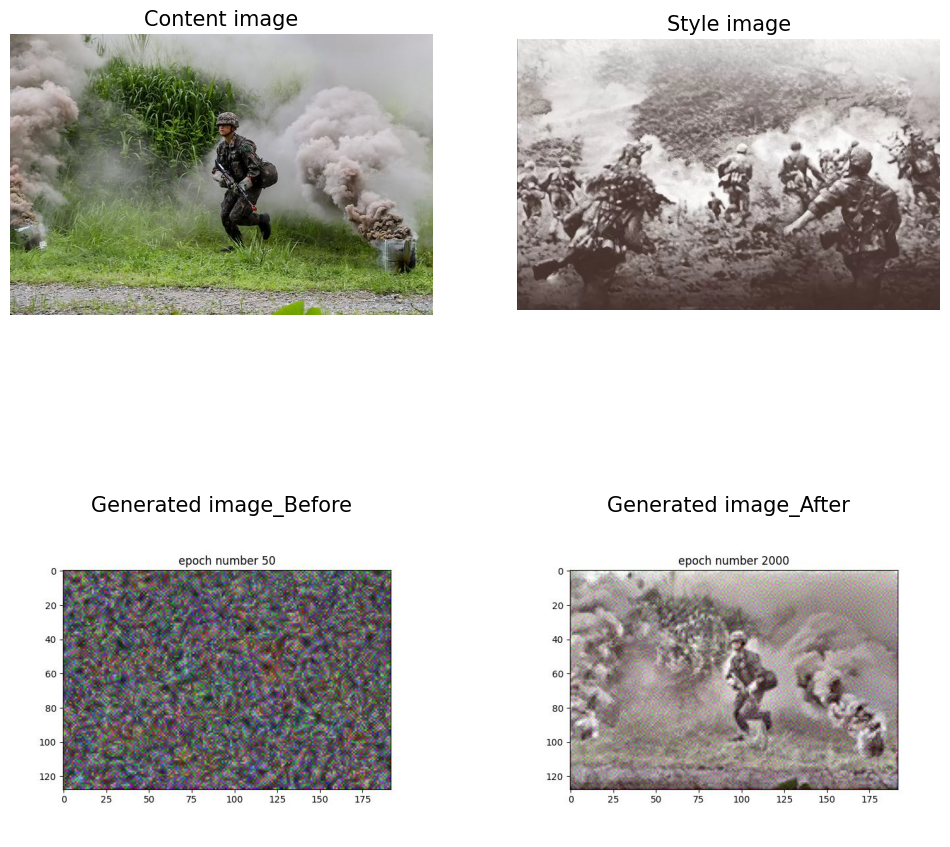

In [ ]:
import cv2
fig = plt.figure(figsize=(12,12))
rows = 2
cols = 2

img1 = cv2.imread('/content/AI_Trend_Edu/소대전투.jpg',cv2.COLOR_BGR2RGB)
img2 = cv2.imread('/content/AI_Trend_Edu/625.jpg',cv2.COLOR_BGR2RGB)
img3 = cv2.imread('/content/AI_Trend_Edu/result_50.jpg')
img4 = cv2.imread('/content/AI_Trend_Edu/result_2000.jpg')

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title('Content image', fontsize=15)
ax1.axis("off")

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title('Style image', fontsize=15)
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax3.set_title('Generated image_Before', fontsize=15)
ax3.axis("off")

ax4 = fig.add_subplot(rows, cols, 4)
ax4.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
ax4.set_title('Generated image_After', fontsize=15)
ax4.axis("off")

plt.show()